## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 70 kB 7.3 MB/s 
     |████████████████████████████████| 1.1 MB 30.6 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 288 kB 57.3 MB/s 
     |████████████████████████████████| 112 kB 58.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 60.3 MB/s 
     |████████████████████████████████| 144 kB 56.0 MB/s 
     |████████████████████████████████| 749 kB 37.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169693, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.3681224421044965,
 0.3666761357169847,
 0.3669666716743376,
 0.36687325585100816,
 0.3669830604152725,
 0.36740680041700247,
 0.3675435553552488,
 0.36703268188088123,
 0.36734679941546833,
 0.3672797876747564]

## Train CNN-LSTM model using full data set

In [7]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
btc_model.sats2model()

In [8]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220625_14_16'

In [9]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220624_16_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, epochs=20)

Epoch 1/20
11/11 [==============================] - 30s 526ms/step - loss: 0.2049 - val_loss: 0.1471
Epoch 2/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0549 - val_loss: 0.0758
Epoch 3/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0371 - val_loss: 0.0691
Epoch 4/20
11/11 [==============================] - 1s 100ms/step - loss: 0.0201 - val_loss: 0.0082
Epoch 5/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0144 - val_loss: 0.0090
Epoch 6/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0225 - val_loss: 0.0377
Epoch 7/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0174 - val_loss: 0.0140
Epoch 8/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 9/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 10/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0088 - val_loss: 0.0126


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


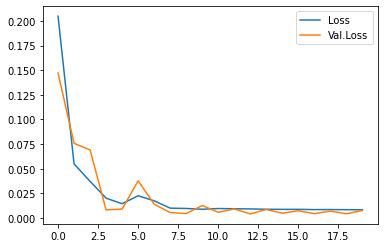

In [10]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [11]:
btc_model.sats2train(model_name, epochs=100)

Epoch 1/100
11/11 [==============================] - 1s 107ms/step - loss: 0.0083 - val_loss: 0.0047
Epoch 2/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 3/100
11/11 [==============================] - 1s 88ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 4/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 5/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 6/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 7/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0079 - val_loss: 0.0045
Epoch 8/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 9/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 10/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0077 - val_loss: 0

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


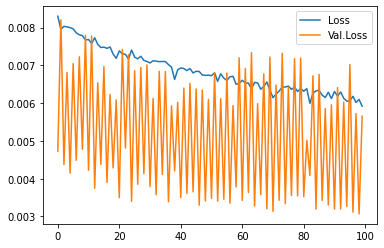

In [12]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [32]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.y_test)
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

array([39334.9246289 , 39331.6972204 , 39329.4583285 , ...,
       22109.04419547, 22087.44412581, 22068.46918964])

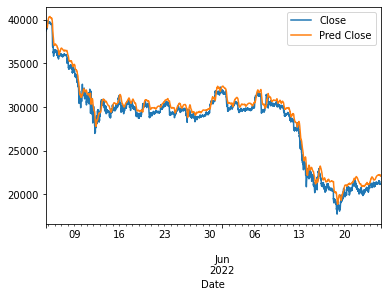

In [33]:
import src.timeutils as tu
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.dropna().plot()

## Test on pretrained model

In [16]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.90)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.53246313],
       [0.53243375],
       [0.53241336],
       ...,
       [0.37562397],
       [0.3754273 ],
       [0.37525454]], dtype=float32)

In [85]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

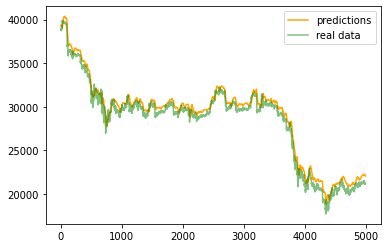

In [86]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

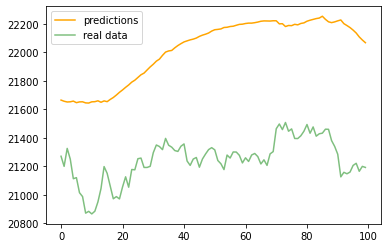

In [52]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

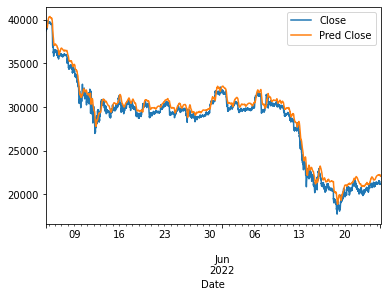

In [165]:
import src.timeutils as tu
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,period = 0)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)

df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 0)
df_preds_true.dropna().plot()

In [89]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-04 13:31:00,38935.85,39334.924629
2022-05-04 13:46:00,38712.06,39331.697220
2022-05-04 14:01:00,38839.20,39329.458328
2022-05-04 14:16:00,38856.97,39315.167390
2022-05-04 14:31:00,38840.51,39323.671251
...,...,...
2022-06-25 13:16:00,21206.54,22156.918513
2022-06-25 13:31:00,21221.56,22136.486987
2022-06-25 13:46:00,21165.45,22109.044195


In [90]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back:])

array([38935.85, 38712.06, 38839.2 , ..., 21165.45, 21199.95, 21192.59])

In [ ]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "longshort", fee=0.025)

s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

Fee: 0.025
----------------------
Buy      0 ( 0 ok 0 ko )
No-op    4996
Wallet   0
Drawback 0
Total earned 0


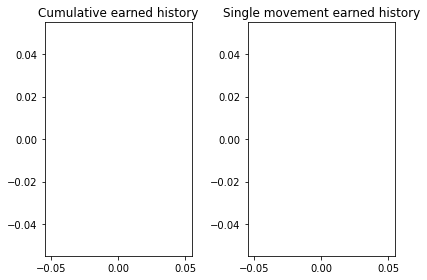

In [23]:
total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [169]:
def kelly_exp_returns(returns):

  drift = np.mean(returns)
  variance = np.var(returns)
  kelly_frac = drift/variance
  return kelly_frac

def kelly_exp_simple(pct_gain,pct_loss,n_wins):

  win_loss_ratio = pct_gain/pct_loss
  kelly_frac = n_wins - (1- n_wins)/win_loss_ratio
  return kelly_frac

def backtest_df(df_preds_true, step_back, long_short = "long", fee=0.025):

    if long_short != "long" and long_short != "short" and long_short != "longshort":
        raise ValueError("Can only have long, short or longshort")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0
    mean_pct_gain = 0
    mean_pct_loss = 0

    delta = df_preds_true.index[1]-df_preds_true.index[0]
    df_preds_true.iloc[:,0] = df_preds_true.iloc[:,0].shift(ts_btc.step_back,delta)

    previous_true_close = df_preds_true.iloc[0,0]
    previous_pred_close = df_preds_true.iloc[0,-1]

    for index, row in df_preds_true.iloc[1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]

        if long_short == "long":
            if previous_true_close + previous_true_close*fee < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)                   

                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "short":
            if  previous_true_close*(1+fee) > pred_close:  # short
                profit = -1*(true_close - previous_true_close)
                if profit > 0:
                    # win
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)             
                else:
                    #loss
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        elif long_short == "longshort":
            if  previous_true_close *(1+fee) > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1*(profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += (previous_true_close/true_close)                  
                else:
                    #loss
                    profit = -1*(profit + (profit * fee))
                    buys_cnt_losses += 1
                    #if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += (previous_true_close/true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            elif previous_true_close *(1+fee) < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += (true_close/previous_true_close)
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += (true_close/previous_true_close)
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1

        previous_true_close = true_close
        previous_pred_close = pred_close

    mean_pct_gain /= buys_cnt_win
    mean_pct_loss /= buys_cnt_losses
    
    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('Avg PCT gain:', mean_pct_gain)
    print('Avg PCT loss:', mean_pct_loss)
    print('Wins    ', buys_cnt/len(df_preds_true))
    print('Avg Gain.   ', buys_cnt_win/buys_cnt_losses)
    print('No-op   ', len(df_preds_true) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    kelly_frac = kelly_exp_simple(mean_pct_gain,mean_pct_loss,buys_cnt_win/len(df_preds_true))

    print('Kelly Fraction   ',kelly_frac)

    return total_wallet_history, single_wallet_history, wallet, kelly_frac

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Fee: 0.025
----------------------
Buy      4947 ( 2709 ok 2238 ko )
Avg PCT gain: 1.003397871956059
Avg PCT loss: 0.997210314174807
Wins     0.9901921537229784
Avg Gain.    1.210455764075067
No-op    49
Wallet   69202.93749999991
Drawback -1993.8197499999987
Kelly Fraction    0.08729043722472063
Total earned 69202.93749999991


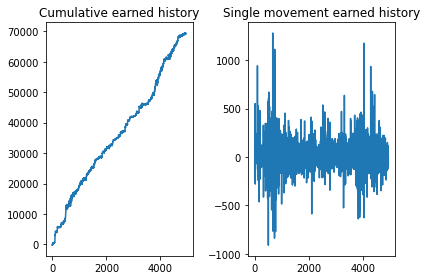

In [171]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "longshort", fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [55]:
def backtest_debug(preds, true_vals, split_point, step_back, fee=0.025):


        wallet = 0
        total_wallet_history = []
        single_wallet_history = []

        buys_cnt = 0
        buys_cnt_win = 0
        buys_cnt_losses = 0
        drawback = 0
        old_profit_negative = False
        old_profits = 0

        for i in range(split_point, len(true_vals) - step_back):
            predicted_close = preds[i - split_point]
            previous_close = true_vals[i]
            real_next_close = true_vals[i+1]

            if (previous_close + (previous_close * fee)) < predicted_close:  # buy
                profit = real_next_close - previous_close

                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        print('Fee:', fee)
        print('----------------------')
        print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
#        print('No-op   ', (len(self.x_candles) - split_point) - buys_cnt)
        print('Wallet  ', wallet)
        print('Drawback', drawback)

        return total_wallet_history, single_wallet_history, wallet

In [58]:
len(true_vals)
len(preds)

4996

Fee: 0.025
----------------------
Buy      1646 ( 934 ok 712 ko )
Wallet   28124.786250000005
Drawback -1549.9947499999987
Total earned 28124.786250000005


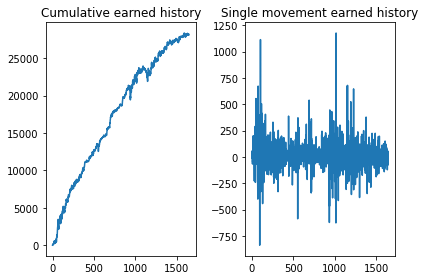

In [56]:
total_wallet_history, single_wallet_history, wallet = backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [83]:
def backtest_debug_2(preds, true_vals, split_point, step_back, fee=0.025):


        wallet = 0
        total_wallet_history = []
        single_wallet_history = []

        buys_cnt = 0
        buys_cnt_win = 0
        buys_cnt_losses = 0
        drawback = 0
        old_profit_negative = False
        old_profits = 0

        for i in range(len(true_vals) - step_back):
            predicted_close = preds[i]
            previous_close = true_vals[i]
            real_next_close = true_vals[i+1]

            if (previous_close + (previous_close * fee)) < predicted_close:  # buy
                profit = real_next_close - previous_close

                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0

        print('Fee:', fee)
        print('----------------------')
        print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
#        print('No-op   ', (len(self.x_candles) - split_point) - buys_cnt)
        print('Wallet  ', wallet)
        print('Drawback', drawback)

        return total_wallet_history, single_wallet_history, wallet

Fee: 0.025
----------------------
Buy      1646 ( 934 ok 712 ko )
Wallet   28124.786250000005
Drawback -1549.9947499999987
Total earned 28124.786250000005


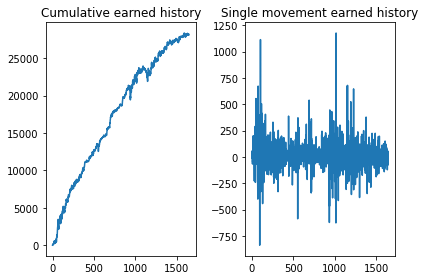

In [84]:
total_wallet_history, single_wallet_history, wallet = backtest_debug_2(preds, true_vals[btc_model.split_point:], btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

In [82]:
len(true_vals[btc_model.split_point:])

5044

In [73]:
len(preds)

4996